# Robust and stochastic optimal control

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    MX, DM, Function, Opti, integrator,
    vcat, hcat, vertcat, horzcat,
    sum1, sum2, sumsqr, sin, cos,
    gradient, jacobian, hessian
)

import casadi
casadi.__version__

'3.6.5'

In [2]:
# Physical constants

T = 1.0 # control horizon [s]
N = 40 # Number of control intervals

dt = T/N # length of 1 control interval [s]

tgrid = np.linspace(0, T, N+1)

## Continuous system $\dot{x}=f(x,u)$

In [3]:
nx = 2

# Construct a CasADi function for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u')
rhs = vertcat(x2, -0.1 * (1 - x1**2) * x2 - x1 + u)
x = vertcat(x1, x2)

x1_bound = lambda t: 2 + 0.1 * cos(10 * t)

## Discrete system $x_{k+1} = F(x_k,u_k)$

In [4]:
opts = dict()
opts["tf"] = dt
intg = integrator('intg', 'cvodes', {'x': x, 'p': u, 'ode': rhs}, opts)

CasADi - 2024-04-24 16:29:38 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


## Optimal control problem, multiple shooting

In [5]:
x0 = vertcat(0.5, 0)

opti = casadi.Opti()

# Decision variable for states
x = opti.variable(nx)

# Initial constraints
opti.subject_to(x == x0)

U = []
X = [x]
# Gap-closing shooting constraints
for k in range(N):
  u = opti.variable()
  U.append(u)

  x_next = opti.variable(nx)
  res = intg(x0=x, p=u)
  opti.subject_to(x_next == res["xf"])

  opti.subject_to(opti.bounded(-40, u, 40))
  opti.subject_to(opti.bounded(-0.25, x[0], x1_bound(tgrid[k])))
  
  x = x_next
  X.append(x)

opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound(tgrid[N])))
U = hcat(U)
X = hcat(X)

opti.minimize(sumsqr(X[0, :] - 3))

opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      322
Number of nonzeros in inequality constraint Jacobian.:       81
Number of nonzeros in Lagrangian Hessian.............:      241

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality c

## Post-processing: plotting

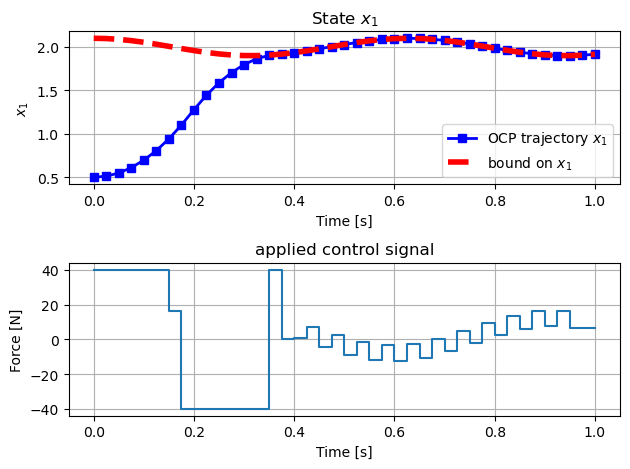

In [6]:
# Simulate forward in time using an initial state and control vector
usol = sol.value(U)
xsol = sol.value(X)

fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.plot(tgrid, xsol[0, :].T, 'bs-', linewidth=2)
ax.plot(tgrid, x1_bound(tgrid), 'r--', linewidth=4)
ax.set_title('State $x_1$')
ax.legend(('OCP trajectory $x_1$', 'bound on $x_1$'))
ax.set_xlabel('Time [s]')
ax.set_ylabel('$x_1$')
ax.grid()

ax = axes[1]
ax.step(tgrid, vertcat(usol, usol[-1]))
ax.set_title('applied control signal')
ax.set_ylabel('Force [N]')
ax.set_xlabel('Time [s]')
ax.grid()

plt.tight_layout()
plt.show()